In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Identification'

/content/drive/My Drive/Siamese/Identification


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')

In [4]:
!pip install torchaudio

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 6
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3 seconds
lenght test loader  2134


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
              time=False)

net.load_encoder(size=3)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

conf_gold_label = None
conf_pred_label = None

with torch.no_grad():
  max_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()
      # Confusion matrix
      conf_gold_label = []
      conf_pred_label = []

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      if conf_gold_label != None:
        conf_gold_label.append(gold_label)
      if conf_pred_label != None:
        conf_pred_label.append(min_label)      

      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    accuracy = topk_accuracy

    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)
    if accuracy > max_accuracy:
      net.store(20, 1)
      max_accuracy = accuracy

  net.store(20, 3)
  means = net.dumpstats()

*** Epoch  0  ***


2134it [00:53, 39.78it/s]

accuracy mean  0.5098406747891284 topk 0.7441424554826617  min  0.746485473289597
Error  0.25585754451733833
{270: 1, 272: 42, 273: 25, 274: 11, 275: 77, 276: 23, 277: 28, 278: 1, 271: 83, 279: 49, 280: 22, 281: 20, 282: 11, 283: 26, 285: 40, 284: 4, 286: 10, 287: 100, 288: 52, 289: 9}
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1.pt
*** Epoch  1  ***



2134it [00:54, 39.33it/s]

accuracy mean  0.6640112464854733 topk 0.8078725398313027  min  0.7905342080599812
Error  0.19212746016869728
{270: 5, 272: 42, 273: 32, 274: 11, 275: 25, 276: 15, 277: 11, 278: 1, 271: 30, 279: 28, 280: 25, 281: 21, 282: 8, 283: 27, 285: 11, 284: 2, 286: 12, 287: 72, 288: 33, 289: 10}
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1.pt
*** Epoch  2  ***



2134it [00:53, 39.54it/s]

accuracy mean  0.7282099343955014 topk 0.8219306466729147  min  0.8083411433926898
Error  0.1780693533270853
{270: 6, 272: 30, 273: 32, 274: 11, 275: 10, 276: 13, 277: 11, 278: 3, 271: 20, 279: 9, 280: 32, 281: 30, 282: 15, 283: 32, 285: 10, 284: 3, 286: 11, 287: 35, 288: 20, 289: 11}
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1.pt
*** Epoch  3  ***



2134it [00:54, 39.33it/s]

accuracy mean  0.7460168697282099 topk 0.8252108716026242  min  0.8059981255857545
Error  0.17478912839737581
{270: 6, 272: 30, 273: 32, 274: 12, 275: 12, 276: 12, 277: 14, 278: 3, 271: 16, 279: 7, 280: 31, 281: 32, 282: 15, 283: 31, 285: 15, 284: 3, 286: 11, 287: 20, 288: 16, 289: 12}
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1.pt
*** Epoch  4  ***



2134it [00:53, 39.54it/s]

accuracy mean  0.7539831302717901 topk 0.8181818181818182  min  0.7980318650421743
Error  0.18181818181818182
{270: 8, 272: 34, 273: 32, 274: 12, 275: 17, 276: 12, 277: 16, 278: 4, 271: 19, 279: 9, 280: 28, 281: 30, 282: 16, 283: 32, 285: 16, 284: 3, 286: 12, 287: 14, 288: 16, 289: 11}
*** Epoch  5  ***
activate stats



2134it [00:58, 36.55it/s]


accuracy mean  0.7432052483598875 topk 0.810215557638238  min  0.7952202436738519
Error  0.18978444236176195
{270: 7, 272: 36, 273: 35, 274: 12, 275: 17, 276: 12, 277: 19, 278: 5, 271: 16, 279: 12, 280: 32, 281: 34, 282: 16, 283: 33, 285: 13, 284: 3, 286: 13, 287: 14, 288: 16, 289: 11}
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_3.pt
Stats for  270  :  tensor([ 7.7705,  8.0690,  8.2586,  8.4168,  8.5463,  8.6577,  8.7657,  8.8726,
         8.9919,  9.1152,  9.2266,  9.3418,  9.4655,  9.5915,  9.7136,  9.8451,
        10.0024, 10.1911, 10.3790, 10.9454], device='cuda:0')
Stats for  272  :  tensor([ 7.3790,  7.9242,  8.2513,  8.4885,  8.6782,  8.8467,  8.9969,  9.1582,
         9.3316,  9.4948,  9.6481,  9.7988,  9.9725, 10.1265, 10.2973, 10.5631,
        10.7708, 10.9646, 11.2112, 11.5509], device='cuda:0')
Stats for  273  :  tensor([ 8.1355,  8.4974,  8.7209,  8.8820,  9.0283,  9.1611,  9.2777,  9.3887,
         9.5005,  9.6088,  9.7207,  9.8336,  9.9

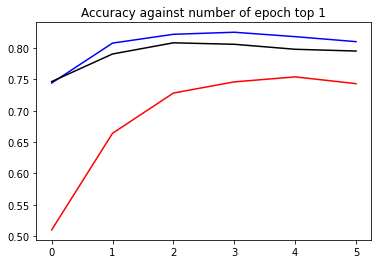

In [11]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [12]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.808
maximum of topk 0.825
maximum of mean 0.754


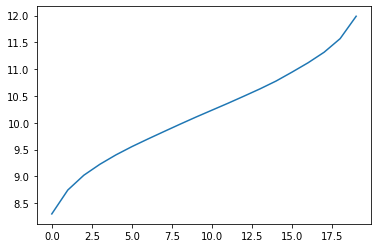

In [13]:
plt.plot(means.cpu())

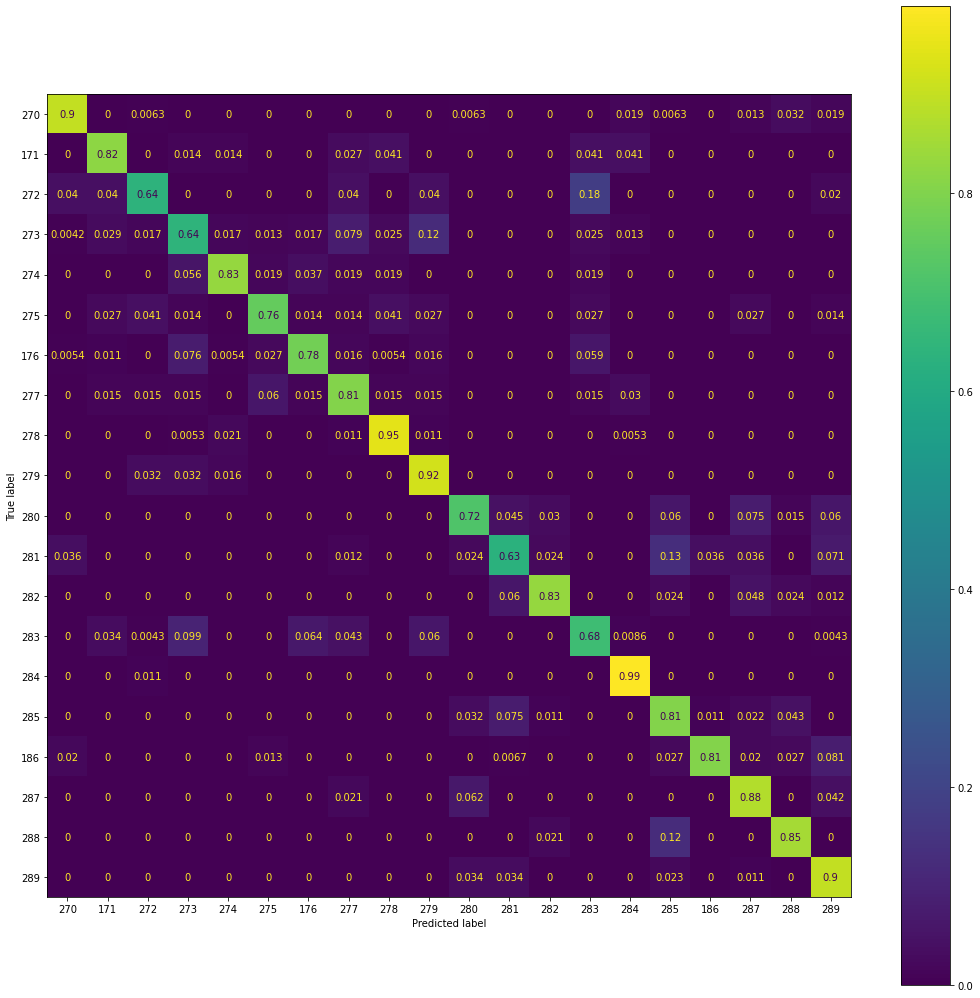

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='true')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

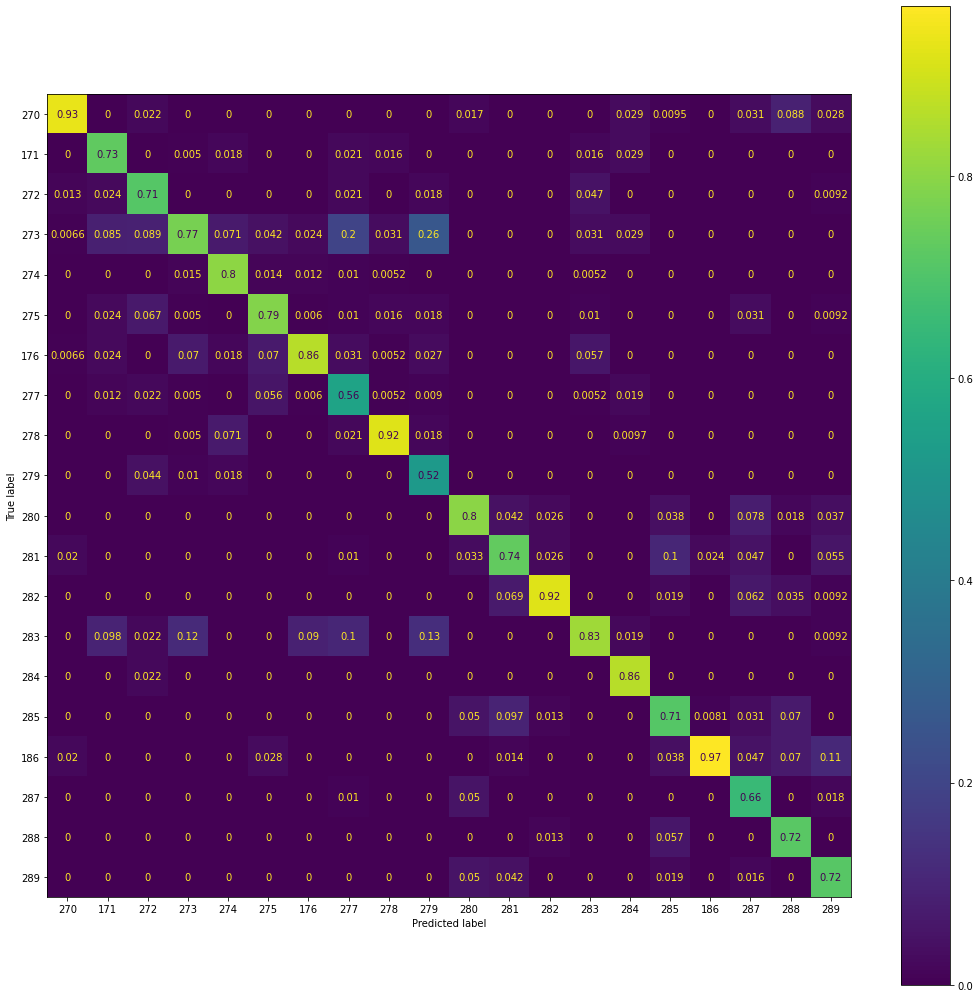

In [15]:
cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='pred')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

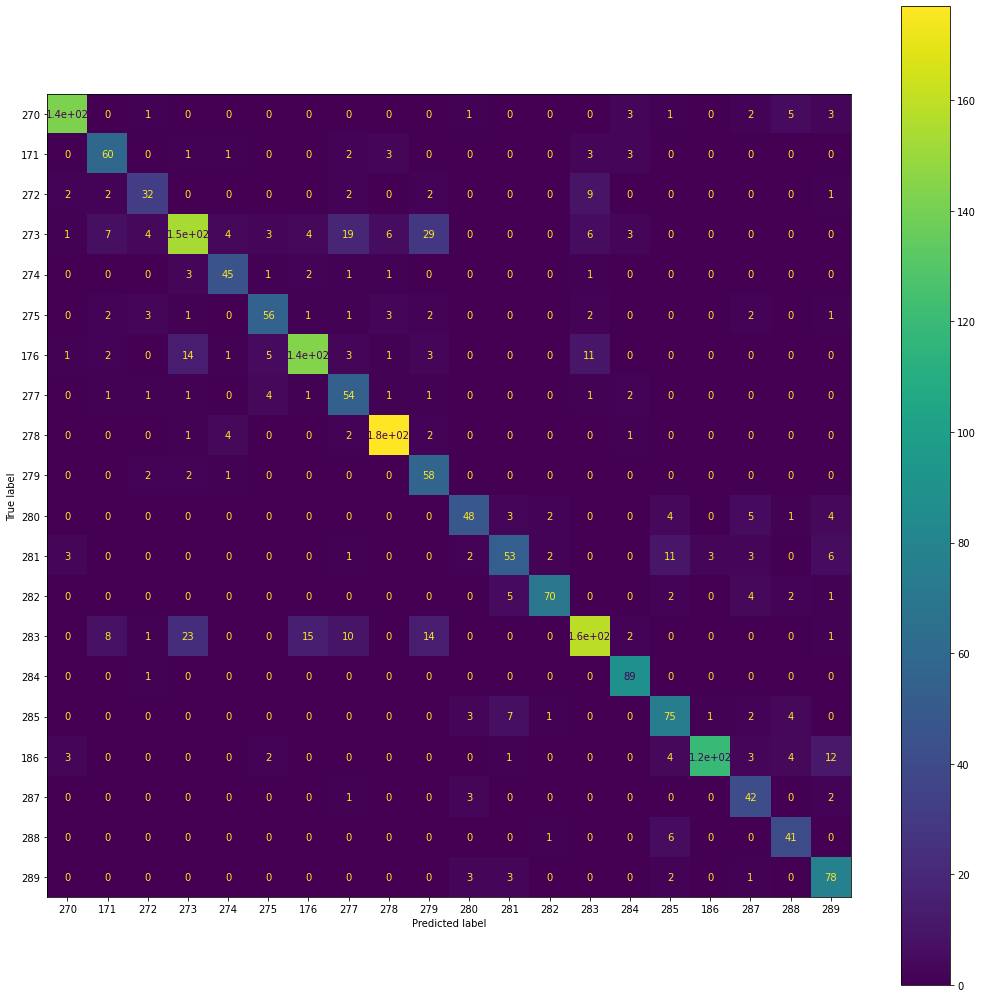

In [16]:
cm = confusion_matrix(conf_gold_label, conf_pred_label)
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

In [17]:
from sklearn.metrics import f1_score

score = f1_score(conf_gold_label, conf_pred_label, average='micro')
print(score)
score = f1_score(conf_gold_label, conf_pred_label, average='weighted')
print(score)

0.7952202436738519
0.7963688441950612
